<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Energiaperpanell_1any.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energia anual per panell (kWh/any): 828.9971875582361


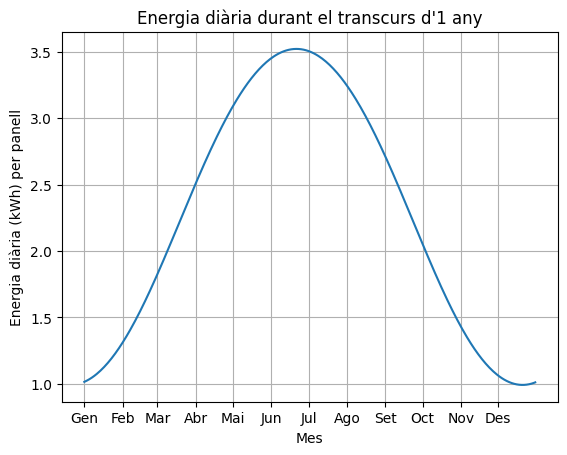

In [22]:
import numpy as np
import matplotlib.pyplot as plt

latitud= 41.50320 * np.pi / 180   # Latitud Bellaterra en radians
area_panell= 2  # m^2
pot_max= 400    # Energia elèctrica generada per panell (W)
irr_ref= 1000   # Irradiància a la qual es genera energia_max (W/m^2)
objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu

# Discretització temporal (un dia)
periode_dia= 24 * 3600
dt= 1 # (s)
omega= 2 * np.pi / periode_dia


# RK4 AIXÒ SERÀ SUBSTITUIT PEL QUE TROBEM DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
eix_rotacio= np.array([0.0, 0.0, 1.0])

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1= derivada(t, v)
    k2= derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3= derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4= derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
# Vector radial a latitud: [cos(latitud), 0, sin(latitud)]
normal_inicial= np.array([np.cos(latitud), 0.0, np.sin(latitud)])

# Precalcula n(t) per un dia
temps_dia= np.zeros(periode_dia + 1)
normal_dia= np.zeros((periode_dia + 1, 3))

t= 0.0
v= normal_inicial.copy()

for i in range(periode_dia + 1):
    normal_dia[i]= v / np.linalg.norm(v)
    temps_dia[i]= t
    if i < periode_dia:
        v= pas_rk4(derivada_vector, t, v, dt)
        v= v / np.linalg.norm(v)   # renormalitza
        t += dt


# Model solar anual: declinació delta(dia) i direcció del Sol s(delta)
# s es fixa durant el dia i només canvia amb el dia de l'any
def declinacio_solar(dia_any):
    # dia_any= 1..365 (aprox clàssica)
    return 23.44 * np.pi / 180* np.sin(2*np.pi*(dia_any - 81)/365.0)

def direccio_sol_unitaria(delta):
    # Direcció del Sol en el sistema inertial:
    # al migdia solar estaria al pla x-z; fem servir s= [cosδ, 0, sinδ]
    s= np.array([np.cos(delta), 0.0, np.sin(delta)])
    return s / np.linalg.norm(s)

# AQUÍ ACABA LA PART DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


def energia_anual_per_panell_kWh():
    energia_any_J= 0.0
    energia_diaria_kWh= np.zeros(365)

    for dia_any in range(1, 366):
        delta= declinacio_solar(dia_any)
        sol_unit= direccio_sol_unitaria(delta)

        # cos(alpha)= n·s (panell horitzontal => normal= n)
        cos_alpha= np.dot(normal_dia, sol_unit)
        cos_alpha= np.maximum(0.0, cos_alpha)   # de nit o darrere => 0

        irr_perp= irr_ref * cos_alpha           # W/m^2 sobre el panell
        pot= pot_max * (irr_perp / irr_ref)     # escala lineal
        pot= np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1]= energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh= energia_anual_per_panell_kWh()

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)

# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()
